# Neural Cellular Automata Tutorial

## Introduction

Play around with the animation at this [link](https://distill.pub/2020/growing-ca/), on the right you can change some parameters.  

In this notebook you will learn how the Cellular Automata model behind that animation works and how it is trained.  
Finally, you will train a Neural Cellular Automata that represents your favourite image.

## Recap on Cellular Automata

A rigorus mathematical definition of a CA can be found [here](https://plato.stanford.edu/entries/cellular-automata/#SomeBasiNotiResu), however, a more intuitive definition is:

A Cellular Automata (CA) consists of a grid of cells that is iteratively updated using the same transition rule $f$ at each step, the only requirement is that the next state of each cell depends only on its previous state $x_t$ and the state of its neighbors $N(x_t)$.
$$x_{t+1}= f(x_t , N(x_t))$$

To make this definition more intuitive, consider the hat rule:  

Hat rule: a student will wear the hat in the next class if one or the other, but not both, of the two classmates sitting immediately on her left and on her right has the hat in the current class (if nobody wears a hat, a hat is out of fashion; but if both neighbors wear it, a hat is now too popular to be trendy).

Initial class: during the first class in the morning, only one student in the middle shows up with a hat.

In this case we have:
* 1-dimensional lattice of cells on a line.

* $x_t \in \{0, 1\}$ (1 = hat on, 0 = hat off)

* Each cell’s neighborhood is composed by the two nearest cells. If $c_i$ is cell number $i$, then $N(c_i)=\{c_{i−1}, c_{i+1}\}$

* The transition rule $f$ is simple: at each time step $t$, a cell state is 1 if exactly one of the neighboring cells was 1 at $t−1$, 0 otherwise.

We can readily implement the hat rule in python

In [2]:
from typing import List
import pylab as pl
import numpy as np

import torch
import torch.nn.functional as F


class HatRule:
    """The classroom is represented as a list of int where 1 is a student with a hat and 0 is a student without a hat"""
    def __init__(self, size: int = 50):
        self.size = size
        self.classroom = self.get_initial_classroom(size)

    @staticmethod
    def get_initial_classroom(size: int) -> torch.Tensor:
        # In the first class of the morning only the student in the middle has a hat
        classroom = torch.zeros(size, dtype=torch.int8)
        classroom[size // 2] = 1
        return classroom

    def set_classroom(self, classroom: torch.Tensor):
        self.classroom = classroom
    
    def get_classroom(self) -> torch.Tensor:
        return self.classroom.clone()

    def step(self) -> torch.Tensor:
        ## TODO: Write the update rule of the hat rule, to avoid boundary problems avoid updating the cells at the boundary
        next_classroom = self.classroom.clone()
        for i in range(1, self.size - 1):
            next_classroom[i] = (self.classroom[i - 1] + self.classroom[i + 1]) % 2
        return next_classroom

    def evolve(self, n_steps: int) -> torch.Tensor:
        """Evolve the classroom for n_steps steps"""
        for _ in range(n_steps):
            self.classroom = self.step()
        return self.classroom.clone()

    def plot_evolution(self, n_steps: int = 100):
        classrooms = torch.empty((n_steps+1, self.size), dtype=torch.int8)
        classrooms[0] = self.get_classroom()
        for i in range(1, n_steps+1):
            classrooms[i] = self.evolve(1)
        pl.matshow(classrooms.detach().numpy())

If you implemented correctly the `step` method, below you should see a triangular shaped fractal, which is in fact [Sierpiński triangle](https://en.wikipedia.org/wiki/Sierpi%C5%84ski_triangle).

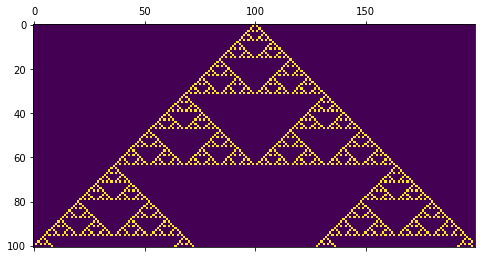

In [14]:
rule = HatRule(size=200)
rule.plot_evolution(n_steps=100)

The above figure is a clear example of emergence:
> The evolutionary pattern displayed contrasts with the simplicity of the underlying law (the “Hat rule”) [...]. The global, emergent behavior of the system supervenes upon its local, simple features.  
> -- <cite>Stanford encyclopedia of Philosophy</cite>

We highly encourage the reader who is interested in Cellular Automata to take a look at the [Stanford encyclopedia of Philosophy article](https://plato.stanford.edu/entries/cellular-automata) about it, where they discuss emergent behaviours, Turing complete cellular automata and the edge of chaos hypothesis among other things.  

Here we will focus on Neural Cellular Automatas

### 2) CA as Convolutional Neural Networks

CA have a clear parallelism to Convolutional Neural Networks (CNN), in this section we will demonstrate it by implementing the hat rule using pytorch 1d convolution operator F.conv1d.

Before implementing the hat rule, we provide a simple yet useful example of how F.conv1d works by computing the running average of a signal.  

### Running average with F.conv1d

The full documentation of F.conv1d can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html#torch.nn.functional.conv1d) however we only need to know a few things:
* The signature is F.conv1d(input, filter)
* input is a tensor of shape (batch_size, n_channels, signal_length)
* filter is a tensor of shape (batch_size, n_channels, filter_length)
* The function returns the result of the convolution, a tensor of shape (batch_size, n_channels, signal_length - (filter_length+1) / 2)
* For the mathematically inclined of you, the operator computes the correlation rather than the convolution

Below you are asked to write the convolutional filter required to compute the running average.

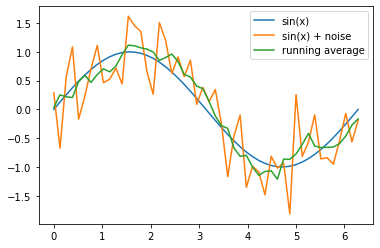

In [12]:
def running_average(input, window_size=3):
    ## TODO: Write the filter to compute the running average of the input
    filter = torch.ones(window_size) / window_size
    # We need to reshape the input and weight tensors, then unravel the output tensor
    return F.conv1d(input.view(1, 1, -1), filter.view(1, 1, -1), padding="same").ravel()

n_points = 50
x = torch.linspace(0, 2 * np.pi, n_points)
y = torch.sin(x)
y_noisy = y + torch.randn(n_points) * 0.5

pl.plot(x, y, label="sin(x)")
pl.plot(x, y_noisy, label="sin(x) + noise")
pl.plot(x, running_average(y_noisy, window_size=5), label="running average")
pl.legend()

If you have implemented it correclty you should see a denoising of the signal.  

Now that we understand how F.conv1d works we can use it to write the transition rule of the hat rule.

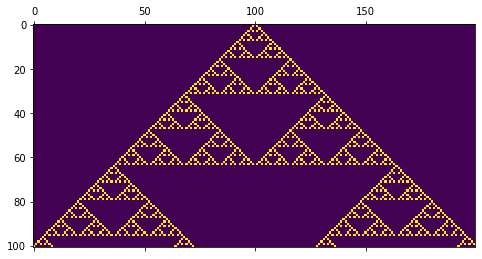

In [15]:
class HatRulePytorch(HatRule):
    def step(self) -> torch.Tensor:
        ## TODO: Write the transition rule of the hat rule using pytorch F.conv1d operator
        weight = torch.tensor([1, 0, 1], dtype=torch.int8)
        return F.conv1d(self.classroom.view(1, 1, -1), weight.view(1, 1, -1), padding="same").ravel() % 2

rule = HatRulePytorch(200)
rule.plot_evolution(100)

### 3) Neural Cellular Automata

Up until now we have dealt with discrete states, while we have shown that these models, although simple, exhibit complex macroscopic behaviour (some of them are even Turing Complete), it turns out that is very difficult to find a CA that, starting from an initial state, reaches a given target state. The main problem is that we can't apply gradient based optimization, because the update rule, having discrete input and output, is not differentiable. Researchers have tried to tackle this using genetic algorithms, which don't require gradient information, however, even finding rules that converge to very simple patterns appears to be difficult.

Neural Cellular Automata (NCA) solve this problem by considering the state $x$ to be continuous and use a neural network to model the rule $f$. This allows to train $f$ using gradient-based optimization.

## References

[1] Berto, Francesco and Jacopo Tagliabue, "Cellular Automata", The Stanford Encyclopedia of Philosophy (Spring 2022 Edition), Edward N. Zalta (ed.), forthcoming URL = <https://plato.stanford.edu/archives/spr2022/entries/cellular-automata/>. 